# Q3 Decision Trees for classification

In [ ]:
import numpy as np
import pandas as pd
import os
import sys
import time
import hashlib
# import a file

from collections import defaultdict

In [3]:
# Using SHA-256 to generate unique seed
username = "m.samartha"
seed = int( hashlib.sha256(username.encode()).hexdigest(),16) % (2**32)
print(seed)
np.random.seed(seed)

def add_username(username = "m.samartha") -> None:
    plt.text(0.95, 0.95, username, ha="right", va="top", transform=plt.gca().transAxes, fontsize=10, color="gray", alpha=0.7)

def add_username_fig(username = "m.samartha", fig=None) -> None:
    if fig is None:
        fig = plt.gcf()
    fig.text(
        0.97, 0.97, "m.samartha",
        ha='right', va='top',
        fontsize=10, color='gray', alpha=0.7
    )

2669878649


In [4]:
import sklearn.tree
import sklearn.linear_model
import sklearn.metrics
import sklearn.ensemble

In [ ]:
def pretty_print_sklearn_tree(tree_clf, feature_names):
    ''' Print out a nice summary of the provided tree.

    Args
    ----
    tree_clf : instance of sklearn.tree.DecisionTreeClassifier
    feature_names : list of strings
        Provides a printable 'name' for each feature the model was trained with.

    Returns
    -------
    Nothing. Results printed to stdout.
    
    Notes
    -----
    Based on an sklearn tutorial. Here's a brief summary of how it works:

    # After training, any DecisionTreeClassifier an attribute called tree_ 
    # which stores the tree structure and allows access to key attributes.
    # The binary tree tree_ is represented as a number of parallel arrays.
    # The i-th element of each array holds information about the node `i`.
    # Node 0 is the tree's root.
    # Notes:
    # - Some of the arrays only apply to either leaves or split nodes, resp.
    # - In this case the values of nodes of the other type are arbitrary!
    #
    # Among those arrays, we have:
    #   - left_child, id of the left child of the node
    #   - right_child, id of the right child of the node
    #   - feature, feature used for splitting the node
    #   - threshold, threshold value at the node
    #   - value, counts of each class for train examples reaching this node

    By manipulating these arrays, we can parse the tree structure.
    '''

    n_nodes = tree_clf.tree_.node_count
    children_left = tree_clf.tree_.children_left
    children_right = tree_clf.tree_.children_right
    feature = tree_clf.tree_.feature
    threshold = tree_clf.tree_.threshold

    # The tree structure can be traversed to compute various properties
    # such as:
    # * the depth of each node 
    # * whether or not it is a leaf.

    node_depth_N = np.zeros(shape=n_nodes, dtype=np.int64)
    is_leaf_N = np.zeros(shape=n_nodes, dtype=bool)
    stack = [(0, -1)]  # seed is the root node id and its parent depth
    while len(stack) > 0:
        node_id, parent_depth = stack.pop()
        node_depth_N[node_id] = parent_depth + 1

        if (children_left[node_id] != children_right[node_id]):
            # Internal decision node
            stack.append((children_left[node_id], parent_depth + 1))
            stack.append((children_right[node_id], parent_depth + 1))
        else:
            # Leaf node
            is_leaf_N[node_id] = True

    print("The binary tree structure has %s nodes." % n_nodes)
    depths_U, counts_U = np.unique(node_depth_N, return_counts=True)
    for uu in range(depths_U.size):
        is_at_cur_depth_N = depths_U[uu] == node_depth_N
        is_leaf_at_cur_depth_N = np.logical_and(
            is_leaf_N,
            is_at_cur_depth_N,
            )
        print("- depth %3d has %4d nodes, of which %4d are leaves" % (
            depths_U[uu], counts_U[uu], np.sum(is_leaf_at_cur_depth_N)))

    print("The decision tree:  (Note: Y = 'yes' to above question; N = 'no')")
    n_seen_by_depth = defaultdict(int)

    for i in range(n_nodes):
        cur_depth = node_depth_N[i]
        count_at_cur_depth = n_seen_by_depth[cur_depth]

        # Every other printout at same depth should alternate Y and N labels
        if node_depth_N[i] == 0:
            decision_str = '' # base case
        elif count_at_cur_depth % 2 == 0:
            decision_str = 'Y '
        else:
            decision_str = 'N '

        if is_leaf_N[i]:
            n_class0 = tree_clf.tree_.value[i,0,0]
            n_class1 = tree_clf.tree_.value[i,0,1]
            proba1 = n_class1 / (n_class1 + n_class0)
            print("%s%sLeaf: p(y=1 | this leaf) = %.3f (%d total training examples)" % (
                node_depth_N[i] * "  ", decision_str, proba1, n_class0 + n_class1))

        else:
            print("%s%sDecision: X['%s'] <= %.2f?" % (
                node_depth_N[i] * "  ",
                decision_str,
                feature_names[feature[i]],
                threshold[i],
                ))

        # Increment our counter so we get the alternating Y/N labels right
        n_seen_by_depth[cur_depth] += 1

    print()

In [6]:
# Plotting utils
import matplotlib
import matplotlib.pyplot as plt

plt.style.use('seaborn-v0_8') # pretty matplotlib plots

import seaborn as sns
sns.set('notebook', font_scale=1.25, style='whitegrid')

### Load all data from train/valid/test

In [ ]:
# https://iiithydstudents-my.sharepoint.com/:u:/g/personal/m_samartha_students_iiit_ac_in/IQCw2ZJM1_8ERb8NQhBdeeS1AVgWvwS-tA83DpTgiQMmH48?e=AEIA3a
# Use the above link to download the data and place it in the appropriate directory

data_dir = "./data_product_reviews"  # Update this path as needed

print(f"Loading data from: {data_dir}")

try:
    # --- Load Training Data ---
    x_train_path = os.path.join(data_dir, 'x_train.csv')
    
    # We use pandas to easily read the CSV, 
    # automatically skipping the header (row 0).
    # dtype=np.float64 ensures features are floats, as expected by the model
    df_x_train = pd.read_csv(x_train_path, dtype=np.float64)
    
    # You can optionally store the vocabulary (the column headers)
    vocab_list = list(df_x_train.columns)
    
    # Convert the pandas DataFrame to a numpy array
    x_train_NF = df_x_train.values

    y_train_path = os.path.join(data_dir, 'y_train.csv')
    # dtype=np.int32 is good for 0/1 labels
    df_y_train = pd.read_csv(y_train_path, dtype=np.int32)
    # .values gives 2D (N,1) array, .ravel() flattens it to 1D (N,)
    y_train_N = df_y_train.values.ravel()


    # --- Load Validation Data ---
    x_valid_path = os.path.join(data_dir, 'x_valid.csv')
    df_x_valid = pd.read_csv(x_valid_path, dtype=np.float64)
    # We re-use the column names from train, assuming they are the same
    # or just convert to numpy directly
    x_valid_VF = df_x_valid.values
    
    y_valid_path = os.path.join(data_dir, 'y_valid.csv')
    df_y_valid = pd.read_csv(y_valid_path, dtype=np.int32)
    y_valid_V = df_y_valid.values.ravel()


    # --- Load Test Data ---
    x_test_path = os.path.join(data_dir, 'x_test.csv')
    df_x_test = pd.read_csv(x_test_path, dtype=np.float64)
    x_test_TF = df_x_test.values
    
    y_test_path = os.path.join(data_dir, 'y_test.csv')
    df_y_test = pd.read_csv(y_test_path, dtype=np.int32)
    y_test_T = df_y_test.values.ravel()

    # --- Print Summary ---
    print("\nData loading complete.")
    print(f"Vocabulary size: {len(vocab_list)}")
    print(f"First 5 vocab words: {vocab_list[:5]}")
    
    print("\nSuccessfully loaded data shapes:")
    print(f"x_train_NF: {x_train_NF.shape}")
    print(f"y_train_N:  {y_train_N.shape}")
    
    print(f"\nx_valid_VF: {x_valid_VF.shape}")
    print(f"y_valid_V:  {y_valid_V.shape}")
    
    print(f"\nx_test_TF:  {x_test_TF.shape}")
    print(f"y_test_T:   {y_test_T.shape}")
    
    print("\nData types:")
    print(f"x_train_NF type: {x_train_NF.dtype}")
    print(f"y_train_N type:  {y_train_N.dtype}")

except FileNotFoundError as e:
    print(e)
    print("\nError: Could not find data files.")
    print(f"Please update the 'data_dir' variable in the script to point to the correct directory.")
except Exception as e:
    print(f"\nAn unexpected error occurred: {e}")
    print("Please check your file formats and paths.")
    print("Ensure 'pandas' is installed: pip install pandas")


Loading data from: ./data_product_reviews

Data loading complete.
Vocabulary size: 7729
First 5 vocab words: ['good', 'great', 'time', 'book', "don't"]

Successfully loaded data shapes:
x_train_NF: (6346, 7729)
y_train_N:  (6346,)

x_valid_VF: (792, 7729)
y_valid_V:  (792,)

x_test_TF:  (793, 7729)
y_test_T:   (793,)

Data types:
x_train_NF type: float64
y_train_N type:  int32


### Pack training and validation sets into big arrays (so we can use sklearn's hyperparameter search tools)

In [8]:
# Combine training and validation sets
print("\nCombining train and validation sets...")

# Use np.vstack (vertical stack) to stack the feature arrays
# (N, F) and (V, F) -> (N+V, F)
x_tr_val_MF = np.vstack([x_train_NF, x_valid_VF])

# Use np.hstack (horizontal stack) to stack the 1D label arrays
# (N,) and (V,) -> (N+V,)
y_tr_val_M = np.hstack([y_train_N, y_valid_V])

print("Combining complete.")
print(f"x_tr_val_MF shape: {x_tr_val_MF.shape}  (Expected: ({x_train_NF.shape[0] + x_valid_VF.shape[0]}, {x_train_NF.shape[1]}))")
print(f"y_tr_val_M shape:  {y_tr_val_M.shape}   (Expected: ({y_train_N.shape[0] + y_valid_V.shape[0]},))")


Combining train and validation sets...
Combining complete.
x_tr_val_MF shape: (7138, 7729)  (Expected: (7138, 7729))
y_tr_val_M shape:  (7138,)   (Expected: (7138,))


# Problem 2: Decision Trees

In [23]:
from sklearn.tree import DecisionTreeClassifier, export_text
from sklearn.model_selection import GridSearchCV, PredefinedSplit
from sklearn.metrics import balanced_accuracy_score, make_scorer

## 2.1: Train a simple tree and visualize

### Fit the tree

In [24]:
# --- Train a Simple Tree ---
print("\n" + "="*50)
print("  Task 2.1: Train a Simple Tree and Visualize")
print("="*50)

# 1. Instantiate the classifier
simple_tree = DecisionTreeClassifier(
    criterion='gini',
    max_depth=3,
    min_samples_leaf=1,
    min_samples_split=2,
    random_state=101
)

# 2. Train the classifier
print("Training simple tree with max_depth=3...")
simple_tree.fit(x_train_NF, y_train_N)
print("Training complete.")


  Task 2.1: Train a Simple Tree and Visualize
Training simple tree with max_depth=3...
Training complete.


### Evaluate the basic decision tree

In [36]:
# --- Evaluate the Basic Decision Tree Model ---
print("\n--- Evaluating basic Decision Tree Model Performance ---")

# Make predictions
print("Making predictions on train, valid, and test sets...")
y_train_pred = simple_tree.predict(x_train_NF)
y_valid_pred = simple_tree.predict(x_valid_VF)
y_test_pred = simple_tree.predict(x_test_TF)

# Calculate Balanced Accuracy (BAcc)
train_bacc = balanced_accuracy_score(y_train_N, y_train_pred)
valid_bacc = balanced_accuracy_score(y_valid_V, y_valid_pred)
test_bacc = balanced_accuracy_score(y_test_T, y_test_pred)

print("\nBalanced Accuracy (BAcc) Scores:")
print(f"  Training Set:   {train_bacc:.3f}")
print(f"  Validation Set: {valid_bacc:.3f}")
print(f"  Test Set:       {test_bacc:.3f}")



--- Evaluating basic Decision Tree Model Performance ---
Making predictions on train, valid, and test sets...

Balanced Accuracy (BAcc) Scores:
  Training Set:   0.646
  Validation Set: 0.645
  Test Set:       0.646


### Print Tree

In [10]:
# 3. Show the ASCII-text representation
pretty_print_sklearn_tree(simple_tree, vocab_list)

The binary tree structure has 15 nodes.
- depth   0 has    1 nodes, of which    0 are leaves
- depth   1 has    2 nodes, of which    0 are leaves
- depth   2 has    4 nodes, of which    0 are leaves
- depth   3 has    8 nodes, of which    8 are leaves
The decision tree:  (Note: Y = 'yes' to above question; N = 'no')
Decision: X['great'] <= 0.50?
  Y Decision: X['excel'] <= 0.50?
    Y Decision: X['disappoint'] <= 0.50?
      Y Leaf: p(y=1 | this leaf) = 0.430 (1 total training examples)
      N Leaf: p(y=1 | this leaf) = 0.114 (1 total training examples)
    N Decision: X['disappoint'] <= 0.50?
      Y Leaf: p(y=1 | this leaf) = 0.903 (1 total training examples)
      N Leaf: p(y=1 | this leaf) = 0.429 (1 total training examples)
  N Decision: X['return'] <= 0.50?
    Y Decision: X['bad'] <= 0.50?
      Y Leaf: p(y=1 | this leaf) = 0.745 (1 total training examples)
      N Leaf: p(y=1 | this leaf) = 0.415 (1 total training examples)
    N Decision: X['movie'] <= 0.50?
      Y Leaf: p(y

### Q. Is there any internal node that has two child leaf nodes corresponding to the same sentiment class? Why would having two children predict the same class make sense?

It is possible for a node in a decision tree to have two children that both predict the same class (for example, both predicting “positive”). This occurs because the Gini criterion (or similar impurity measures) does not aim to change the predicted class at each split—it only seeks to increase the purity of the resulting nodes. In other words, a split is considered beneficial if it reduces the overall impurity, even if the majority class in both children remains the same.
For example, consider a parent node with 100 positive and 20 negative reviews, giving a Gini impurity of 0.278. A split on a feature such as the word “average” might produce two child nodes: one with 20 positive and 10 negative reviews (impurity 0.444) and another with 80 positive and 10 negative reviews (impurity 0.210). The weighted average impurity after the split becomes 0.268, which is lower than 0.278. This means the split improves the model’s ability to separate data—even though both children still predict the “positive” class. The tree has effectively separated a less pure subset from a more pure one, making it a valid and useful split.

## 2.2: Hyperparameter Tuning with Grid Search

In [47]:
print("\n" + "="*50)
print("  Task 2.2: Hyperparameter Tuning (Grid Search)")
print("="*50)

# 1. Create the custom validation split
# -1 = use for training
# 0 = use for validation (in fold 0)

n_train_samples = x_train_NF.shape[0]
n_valid_samples = x_valid_VF.shape[0]

# Create the test_fold array
train_indices = np.full(n_train_samples, -1)
valid_indices = np.full(n_valid_samples, 0)
test_fold_M = np.hstack([train_indices, valid_indices])

# Instantiate the PredefinedSplit
my_splitter = PredefinedSplit(test_fold=test_fold_M)

# 2. Define the parameter grid
param_grid = {
    'max_depth': [2, 8, 32, 128],
    'min_samples_leaf': [1, 3, 9]
}

# 3. Create the base estimator
dt_grid_estimator = DecisionTreeClassifier(
    criterion='gini',
    random_state=101
)

# 4. Set up GridSearchCV
print("Starting GridSearchCV...")
print(f"Hyperparameter grid: {param_grid}")
print(f"Scoring metric: balanced_accuracy")

grid_search = GridSearchCV(
    estimator=dt_grid_estimator,
    param_grid=param_grid,
    scoring='balanced_accuracy',
    cv=my_splitter,
    return_train_score=True,
    refit=False,  # As specified in the instructions
    verbose=1
)

# 5. Run the grid search
grid_search.fit(x_tr_val_MF, y_tr_val_M)

print("\nGridSearchCV complete.")

# 6. Report the results
print("\n--- Grid Search Results ---")

# Best params
best_params = grid_search.best_params_
best_score = grid_search.best_score_

print(f"Best Parameters Found: {best_params}")
print(f"Best Validation Score (balanced_accuracy): {best_score:.4f}")

print("\nFull results table (cv_results_):")
# Convert to DataFrame for easier reading
results_df = pd.DataFrame(grid_search.cv_results_)
print(results_df[['param_max_depth', 'param_min_samples_leaf', 
                    'mean_test_score', 'mean_train_score', 'rank_test_score']])


  Task 2.2: Hyperparameter Tuning (Grid Search)
Starting GridSearchCV...
Hyperparameter grid: {'max_depth': [2, 8, 32, 128], 'min_samples_leaf': [1, 3, 9]}
Scoring metric: balanced_accuracy
Fitting 1 folds for each of 12 candidates, totalling 12 fits

GridSearchCV complete.

--- Grid Search Results ---
Best Parameters Found: {'max_depth': 32, 'min_samples_leaf': 3}
Best Validation Score (balanced_accuracy): 0.7324

Full results table (cv_results_):
    param_max_depth  param_min_samples_leaf  mean_test_score  \
0                 2                       1         0.633931   
1                 2                       3         0.633931   
2                 2                       9         0.633931   
3                 8                       1         0.698887   
4                 8                       3         0.697599   
5                 8                       9         0.696208   
6                32                       1         0.727378   
7                32               

Thus the best hyperparameters found are:
- max_depth: 32
- min_samples_leaf: 3

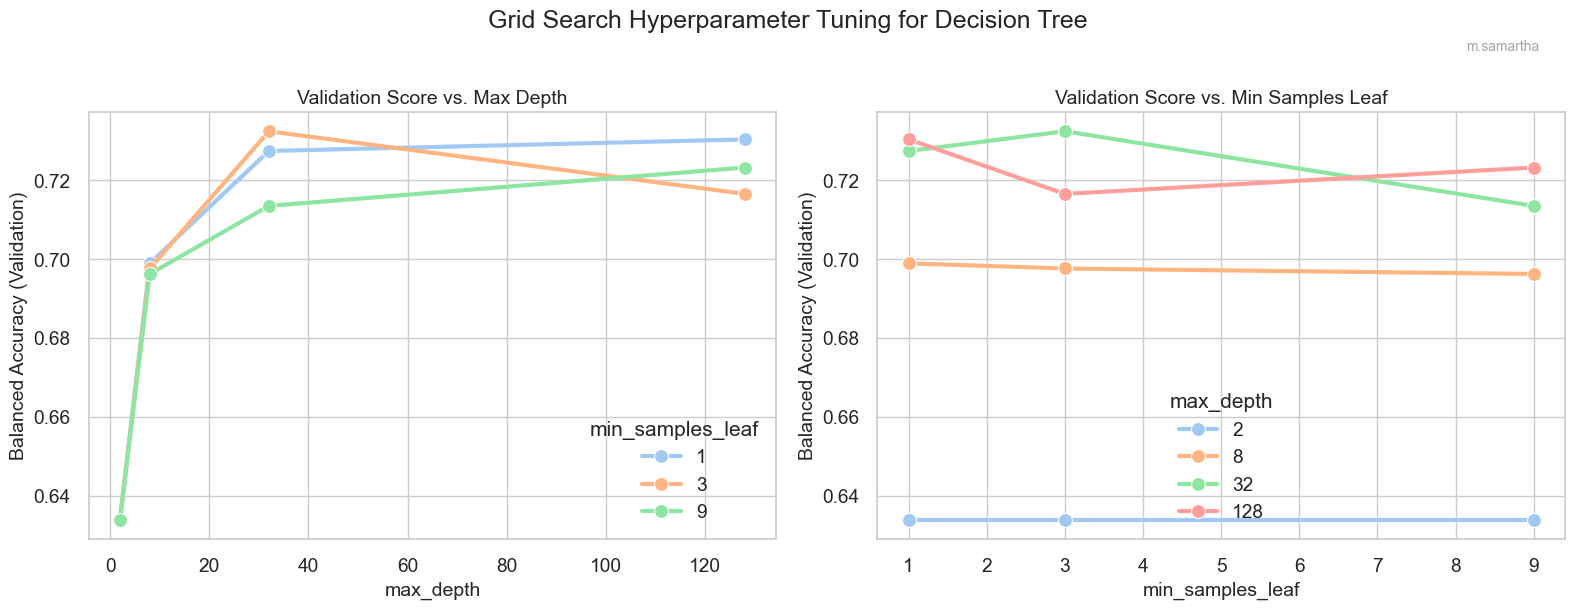

In [48]:
# --- Plotting the Grid Search Results ---
fig, axes = plt.subplots(1, 2, figsize=(16, 6))
fig.suptitle('Grid Search Hyperparameter Tuning for Decision Tree', fontsize=18, y=1.02)

# Plot 1: Validation Score vs. Max Depth
sns.lineplot(
    data=results_df,
    x='param_max_depth',
    y='mean_test_score',
    hue='param_min_samples_leaf',
    marker='o',
    markersize =10,
    palette='pastel',
    ax=axes[0],
    linewidth=3
)
axes[0].set_title('Validation Score vs. Max Depth', fontsize=14)
axes[0].set_xlabel('max_depth', fontsize=14)
axes[0].set_ylabel('Balanced Accuracy (Validation)', fontsize=14)
axes[0].legend(title='min_samples_leaf')
axes[0].grid(True)

# Plot 2: Validation Score vs. Min Samples Leaf
sns.lineplot(
    data=results_df,
    x='param_min_samples_leaf',
    y='mean_test_score',
    hue='param_max_depth',
    marker='o',
    markersize =10,
    palette='pastel',
    ax=axes[1],
    linewidth=3
)
axes[1].set_title('Validation Score vs. Min Samples Leaf', fontsize=14)
axes[1].set_xlabel('min_samples_leaf', fontsize=14)
axes[1].set_ylabel('Balanced Accuracy (Validation)', fontsize=14)
axes[1].legend(title='max_depth')
axes[1].grid(True)

plt.tight_layout()
add_username_fig(fig=fig)
plt.show()

### Build the best decision tree

In [29]:
print("Configuring best tree with optimal hyperparameters...")
base_tree = DecisionTreeClassifier(random_state=101)
best_tree = base_tree 
best_tree.set_params(**grid_search.best_params_)

Configuring best tree with optimal hyperparameters...


,criterion,'gini'
,splitter,'best'
,max_depth,32
,min_samples_split,2
,min_samples_leaf,3
,min_weight_fraction_leaf,0.0
,max_features,None
,random_state,101
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,class_weight,None


### Fit the best tree

In [30]:
best_tree.fit(x_tr_val_MF, y_tr_val_M)

print("\nBest tree has been successfully fitted.")
print(f"Tree depth after fitting: {best_tree.get_depth()}")


Best tree has been successfully fitted.
Tree depth after fitting: 32


### Evaluate the best decision tree

In [35]:
# --- Evaluate the Best Decision tree Model ---
print("\n--- Evaluating best Decision Tree Model Performance ---")

# Make predictions
print("Making predictions on train, valid, and test sets...")
y_train_pred = best_tree.predict(x_train_NF)
y_valid_pred = best_tree.predict(x_valid_VF)
y_test_pred = best_tree.predict(x_test_TF)

# Calculate Balanced Accuracy (BAcc)
train_bacc = balanced_accuracy_score(y_train_N, y_train_pred)
valid_bacc = balanced_accuracy_score(y_valid_V, y_valid_pred)
test_bacc = balanced_accuracy_score(y_test_T, y_test_pred)

print("\nBalanced Accuracy (BAcc) Scores:")
print(f"  Training Set:   {train_bacc:.3f}")
print(f"  Validation Set: {valid_bacc:.3f}")
print(f"  Test Set:       {test_bacc:.3f}")



--- Evaluating best Decision Tree Model Performance ---
Making predictions on train, valid, and test sets...

Balanced Accuracy (BAcc) Scores:
  Training Set:   0.861
  Validation Set: 0.873
  Test Set:       0.729


### Interpret the best decision tree

In [39]:
pretty_print_sklearn_tree(best_tree, feature_names=vocab_list)

The binary tree structure has 853 nodes.
- depth   0 has    1 nodes, of which    0 are leaves
- depth   1 has    2 nodes, of which    0 are leaves
- depth   2 has    4 nodes, of which    0 are leaves
- depth   3 has    8 nodes, of which    0 are leaves
- depth   4 has   16 nodes, of which    5 are leaves
- depth   5 has   22 nodes, of which    8 are leaves
- depth   6 has   28 nodes, of which   14 are leaves
- depth   7 has   28 nodes, of which   12 are leaves
- depth   8 has   32 nodes, of which   13 are leaves
- depth   9 has   38 nodes, of which   17 are leaves
- depth  10 has   42 nodes, of which   21 are leaves
- depth  11 has   42 nodes, of which   19 are leaves
- depth  12 has   46 nodes, of which   24 are leaves
- depth  13 has   44 nodes, of which   22 are leaves
- depth  14 has   44 nodes, of which   22 are leaves
- depth  15 has   44 nodes, of which   25 are leaves
- depth  16 has   38 nodes, of which   20 are leaves
- depth  17 has   36 nodes, of which   17 are leaves
- dep